<div>
<img src="https://www.nebrija.com/images/logos/logotipo-universidad-nebrija.jpg" width="200">
</div>

**ALGORITMOS** -
Prof: Carmen Pellicer Lostao

# Grover Avanzado - Problemas de satisfacción de restricciones (SAT)

En este notebook vamos a ver como podemos usar las librerías de Qiskit para resolver problemas de Satisfaccion de Restricciones (SAT)

Empezamos con un modelo del como podemos resolverlo y realizamos un ejercicio para aplicar este modelo en un nuevo problema SAT.

En este notebook vamos a necesitar instalar las librerias ['tweedledum'](https://pypi.org/project/tweedledum/) para poder trabajar con las clases `BooleanExpression`

**IMPORTANTE:** Reiniciar el Kernel despues de la instalacion, si no hay dependencias en las librerias ya instaladas en el entorno que no se resuelven bien

In [64]:
#necesita instalarse y tambien quiza re-start kernel y ejecutar todo desde el principio
#!pip install tweedledum

In [65]:
# initialization
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg' # Makes the images look nice
import numpy as np

# importing Qiskit
from qiskit import IBMQ, Aer
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute

# import basic plot tools
from qiskit.visualization import plot_histogram

# import algorithms from Qiskit
from qiskit.algorithms import Grover, AmplificationProblem
from qiskit.circuit.library import PhaseOracle
from qiskit.compiler import transpile
from qiskit.utils import QuantumInstance

## Algoritmo de Grover para resolver problemas de satisfacción de restricciones (SAT)

La búsqueda de Grover es un algoritmo cuántico que se puede utilizar para buscar soluciones a problemas no estructurados cuadráticamente más rápido que sus homólogos clásicos. Aquí, vamos a ilustrar el uso del algoritmo de Grover para resolver un problema de satisfacibilidad booleano combinatorio particular.

El problema de satisfacibilidad booleana es el problema de determinar si existe una combinacion de valores de variables booleanas que satisfaga una fórmula booleana determinada.Para problemas de búsqueda no estructurados, el algoritmo de Grover es óptimo. Si bien no tiene sentido utilizar el algoritmo de Grover en problemas de 3 sat por su simplicidad, las técnicas aquí se pueden aplicar al caso más general (k-SAT) en el que el algoritmo de Grover puede superar al mejor algoritmo clásico. Además, en teoría, las técnicas del algoritmo de Grover se pueden combinar con las técnicas utilizadas en los algoritmos clásicos para obtener un tiempo de ejecución aún mejor que cualquiera de ellos individualmente (incluso con 3-SAT).

### La forma normal conjuntiva (CNF) de un problema SAT

Un problema de satisfaccion de restricciones k-SAT lo expresaremos en **forma normal conjuntiva** (CNF). Los problemas SAT siempre se pueden escribir en lo que se conoce como forma normal conjuntiva (CNF).

En la forma normal conjuntiva CNF, el problema se expresa como una serie de disyunciones de k variables booleanas (OR) unidas por operaciones AND, y se satisface solo si se cumplen todas sus disyunciones. Esto es, la forma normal es una conjunción de una o más cláusulas, donde una cláusula es una disyunción de literales; Dicho de otro modo, es un AND de k clausulas OR

Para que el SAT sea verdadero, debes encontrar y asignar valores apropiados de 0 o 1 a todas sus variables.

Tomamos un ejemplo concreto de un problema de la 3-Satisfacibilidad (3-SAT). Consideremos una función booleana $f$ con tres variables booleanas $v_1,v_2,v_3$ como se muestra a continuación:

$$f(v_1,v_2,v_3) = (\neg v_1 \vee \neg v_2 \vee \neg v_3) \wedge (v_1 \vee \neg v_2 \vee v_3) \wedge (v_1 \vee v_2 \vee \neg v_3) \wedge (v_1 \vee \neg v_2 \vee \neg v_3) \wedge (\neg v_1 \vee v_2 \vee v_3)$$

En la función anterior, los términos de la ecuación del lado derecho que están dentro de $()$ se llaman cláusulas; esta función tiene 5 cláusulas. En un problema de k-SAT, cada cláusula tiene como maximo k literales; Nuestro problema es un problema 3-SAT, por lo que cada cláusula tiene exactamente tres literales o variables. Por ejemplo, la primera cláusula tiene $\neg v_1$, $\neg v_2$ y $\neg v_3$ como literales. El símbolo $\neg$ es el NO booleano que niega (o invierte) el valor de su literal siguiente. Los símbolos $\vee$ y $\wedge$ son, respectivamente, los operadores booleanos OR y AND. El valor booleano $f$ es satisfactorio si hay una asignación de $v_1, v_2, v_3$ que se evalúa como $f(v_1, v_2, v_3) = 1$ (es decir, $f$ se evalúa como Verdadero).

Una forma de encontrar dicha asignación es probar todas las combinaciones posibles de valores de entrada de $f$. A continuación se muestra la tabla obtenida al probar todas las combinaciones posibles de $v_1, v_2, v_3$. Para facilitar la explicación, usamos indistintamente $0$ y False, así como $1$ y True.

|$v_1$ | $v_2$ | $v_3$ | $f$ | Comentar |
|------|-------|-------|-----|---------|
| 0 | 0 | 0 | 1 | **Solución** |
| 0 | 0 | 1 | 0 | No es una solución porque $f$ es falso |
| 0 | 1 | 0 | 0 | No es una solución porque $f$ es falso |
| 0 | 1 | 1 | 0 | No es una solución porque $f$ es falso |
| 1 | 0 | 0 | 0 | No es una solución porque $f$ es falso |
| 1 | 0 | 1 | 1 | **Solución** |
| 1 | 1 | 0 | 1 | **Solución** |
| 1 | 1 | 1 | 0 | No es una solución porque $f$ es falso |

En la tabla anterior, podemos ver que esta instancia del problema 3-SAT tiene tres soluciones satisfactorias: $(v_1, v_2, v_3) = (T, F, T)$ o $(F, F, F)$ o $(T, T, F)$.

En general, la función booleana $f$ puede tener muchas cláusulas y más variables booleanas. Tenga en cuenta que los problemas del SAT siempre se pueden escribir en lo que se conoce como forma normal conjuntiva (CNF), es decir, una conjunción de una o más cláusulas, donde una cláusula es una disyunción de tres literales; Dicho de otro modo, es un AND de k OR.

### Implementacion en Qiskit

Qiskit utiliza el formato de entrada [DIMACS CNF](http://www.satcompetition.org/2009/format-benchmarks2009.html) para resolver los problemas SAT, por lo que es necesario convertir nuestra funcion en formato CNF a DIMACS CNF.

Dada nuestra funcion f:

$$f(v_1,v_2,v_3) = (\neg v_1 \vee \neg v_2 \vee \neg v_3) \wedge (v_1 \vee \neg v_2 \vee v_3) \wedge (v_1 \vee v_2 \vee \neg v_3) \wedge (v_1 \vee \neg v_2 \vee \neg v_3) \wedge (\neg v_1 \vee v_2 \vee v_3)$$

El formato DIMACS CNF lo recogemos en un fichero que tiene la siguiente estructura:

~~~
c ejemplo DIMACS CNF 3-SAT
p cnf 3 5
-1 -2 -3 0
1-2 3 0
1 2 -3 0
1 -2 -3 0
-1 2 3 0
~~~

- Las líneas que empiezan con `c` son comentarios.
    - p.ej. `c ejemplo DIMACS CNF 3-SAT`
- La primera línea que no sea de comentario debe tener el formato `p cnf nbvar nbclauses`, donde
  - `cnf` indica que la entrada está en formato CNF
  - `nbvar` es el número exacto de variables que aparecen en el archivo, en nuestro caso es un problema 3-SAT
  - `nbclauses` es el número exacto de cláusulas contenidas en el archivo, en nuestro caso son 5 disyunciones
  - p.ej. `p cnf 3 5`
- Luego hay una línea para cada cláusula, donde
  - cada cláusula es una secuencia de números distintos no nulos entre `-nbvar` y `nbvar` que terminan con `0` en la misma línea
  - no puede contener los literales opuestos i y -i simultáneamente
  - los números positivos indican las variables correspondientes
  - los números negativos denotan las negaciones de las variables correspondientes
  - p.ej. `-1 2 3 0` corresponde a la cláusula $\neg v_1 \vee v_2 \vee v_3$

De manera similar, las soluciones al problema $(v_1, v_2, v_3) = (T, F, T)$ o $(F, F, F)$ o $(T, T, F)$ se pueden escribir como `1 - 2 3`, o `-1 -2 -3`, o `1 2 -3`.

Con la entrada de este problema de ejemplo, creamos el oráculo correspondiente para nuestra búsqueda de Grover. En particular, utilizamos el componente `PhaseOracle.from_dimacs_file()` proporcionado por Qiskit, que admite el análisis de cadenas en formato DIMACS CNF y la construcción del circuito Oracle correspondiente.

In [66]:
# this indicates that the input is CNF with 3 variables and 5 clauses
input_3sat = '''
c example DIMACS-CNF 3-SAT
p cnf 3 5
-1 -2 -3 0
1-2 3 0
1 2 -3 0
1 -2 -3 0
-1 2 3 0
'''

{   'assignment': '101',
    'circuit_results': [{'011': 512, '101': 512}],
    'iterations': [1],
    'max_probability': 0.5,
    'oracle_evaluation': True,
    'top_measurement': '101'}


/tmp/ipykernel_1660/4137864854.py:7: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024)
/tmp/ipykernel_1660/4137864854.py:11: DeprecationWarning: ``qiskit.algorithms.amplitude_amplifiers.grover.Grover.__init__()``'s argument ``quantum_instance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. Instead, use the ``sampler`` argument. See https://qisk.it/algo_migration for a migration guide.
  grover = Grover(quantum_instance=quantum_instance)


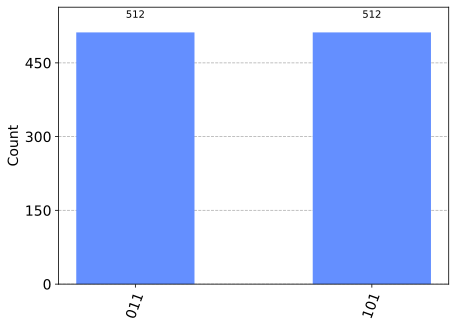

In [67]:
with open("3sat.dimacs", "w") as text_file:
    text_file.write(input_3sat)

oracle = PhaseOracle.from_dimacs_file("3sat.dimacs")

backend = Aer.get_backend('aer_simulator')
quantum_instance = QuantumInstance(backend, shots=1024)
problem = AmplificationProblem(oracle=oracle)

# Use Grover's algorithm to solve the problem
grover = Grover(quantum_instance=quantum_instance)
result = grover.amplify(problem)
print(result)

# we're interested in the top measurement = result that has the highest
# probability to be chosen.
result.top_measurement


plot_histogram(result.circuit_results)

# Interpretation of the result (bit string in right to left order, EDCBA):
# we should invite Alice, Bob, Charlie (1),
# we should not invite Dave and Eve (0).

**IMPORTANTE**: el orden de los qubits en qiskit es $q_{n-1},q_{n-2},...,q_1,q_0$ por lo que $v_1=q_0$, $v_2=q_1$ y $v_3=q_2$ y para interpretar correctamente los resultados hemos de invertir el orden de los qubits de las soluciones obtenidas

## EJERCICIO: Algoritmo de Grover para resolver un problema de satisfacción (5-SAT)

Imagina que estás organizando una fiesta de cumpleaños y necesitas decidir a cuál de tus amigos Alice, Bob, Charlie, Dave y Eve invitas. 

Hay algunas restricciones:

i) Alice y Eve siempre están peleando, así que definitivamente no querrás invitarlas a ambas.

ii) Alice y Charlie están casados, por lo que si invitas a uno de ellos, también debes invitar al otro.

iii) Para animar el ambiente, querrás invitar al menos a uno de tus amigos más entretenidos, Bob y Dave.

iv) Cada vez que los tres chicos, Bob, Charlie y Dave, se juntan, de alguna manera se incitan entre sí y la fiesta podría salirse de control. Así que no los invites a los tres.

v) Sabes que si invitas a Bob, lo más probable es que le pregunte a Alice ideas para un regalo de cumpleaños. Por lo tanto, si invitas a Bob, también deberías invitar a Alice (pero no necesariamente al revés).

vi) Dave sólo vendrá si Bob también viene (aunque no al revés). Así que no tiene sentido invitarlo si Bob no está siendo invitado.

Usa el algoritmo de Grover para determinar qué opciones tiene para posibles listas de invitados.

### Resolución

Tendremos 5 variables y varias cláusulas a tener en cuenta. Lo primero que haremos será asignar las variables a los amigos:

- Alice: $v_1$.
- Bob: $v_2$.
- Charlie: $v_3$.
- Dave: $v_4$.
- Eve: $v_5$.

A continuación, implementaremos el problema utulizando un archivo en formato DIMACS.

In [68]:
# this indicates that the input is CNF with 3 variables and 5 clauses
input_5sat = '''
c Problema 5-SAT
p cnf 5 7
-1 -5 0
1 -3 0
-1 3 0
2 4 0
-2 -3 -4 0
1 -2 0
2 -4 0
'''

Veamos cada cláusula con detenimiento.

#### Cláusula i)

Alice y Eve siempre están peleando, así que definitivamente no querrás invitarlas a ambas. Esto se traduce a la tabla de verdad:

|$v_1$ | $v_5$ | Salida |
|------|-------|-------|
| 0 | 0 | 1 |
| 0 | 1 | 1 |
| 1 | 0 | 1 |
| 1 | 1 | 0 |

Lo implementamos con la línea $\verb|-1 -5 0|$, pues verifica dicha tabla de verdad.

#### Cláusula ii)

Alice y Charlie están casados, por lo que si invitas a uno de ellos, también debes invitar al otro. Esto se traduce a la tabla de verdad:

|$v_1$ | $v_3$ | Salida |
|------|-------|-------|
| 0 | 0 | 1 |
| 0 | 1 | 0 |
| 1 | 0 | 0 |
| 1 | 1 | 1 |

Lo implementamos con las líneas (dos cláusulas), $\verb|1 -3 0|$ y $\verb|-1 3 0|$. La acción de ambas evita los casos $(v_1,v_2) = (1,0)$ y viceversa.

#### Cláusula iii)

Para animar el ambiente, querrás invitar al menos a uno de tus amigos más entretenidos, Bob y Dave. Esto se traduce a la tabla de verdad:

|$v_2$ | $v_4$ | Salida |
|------|-------|-------|
| 0 | 0 | 0 |
| 0 | 1 | 1 |
| 1 | 0 | 1 |
| 1 | 1 | 1 |

Lo implementamos con la línea $\verb|2 4 0|$, pues verifica dicha tabla de verdad.

#### Cláusula iv)

Cada vez que los tres chicos, Bob, Charlie y Dave, se juntan, de alguna manera se incitan entre sí y la fiesta podría salirse de control. Así que no los invites a los tres. Esto se traduce a la tabla de verdad:

|$v_2$ | $v_3$ | $v_4$ | Salida |
|------|-------|-------|-------|
| 0 | 0 | 0 | 1 |
| 0 | 0 | 1 | 1 |
| 0 | 1 | 0 | 1 |
| 0 | 1 | 1 | 1 |
| 1 | 0 | 0 | 1 |
| 1 | 0 | 1 | 1 |
| 1 | 1 | 0 | 1 |
| 1 | 1 | 1 | 0 |

Lo implementamos con la línea $\verb|-2 -3 -4 0|$, pues verifica dicha tabla de verdad.

#### Cláusula v)

Sabes que si invitas a Bob, lo más probable es que le pregunte a Alice ideas para un regalo de cumpleaños. Por lo tanto, si invitas a Bob, también deberías invitar a Alice (pero no necesariamente al revés). Esto se traduce a la tabla de verdad:

|$v_1$ | $v_2$ | Salida |
|------|-------|-------|
| 0 | 0 | 1 |
| 0 | 1 | 0 |
| 1 | 0 | 1 |
| 1 | 1 | 1 |

Lo implementamos con la línea $\verb|1 -2 0|$, pues verifica dicha tabla de verdad.

#### Cláusula vi)

Dave sólo vendrá si Bob también viene (aunque no al revés). Así que no tiene sentido invitarlo si Bob no está siendo invitado. Esto se traduce a la tabla de verdad:

|$v_2$ | $v_4$ | Salida |
|------|-------|-------|
| 0 | 0 | 1 |
| 0 | 1 | 0 |
| 1 | 0 | 1 |
| 1 | 1 | 1 |

Lo implementamos con la línea $\verb|2 -4 0|$, pues verifica dicha tabla de verdad.

Con todo, resolvamos nuestro problema.

In [69]:
with open("5sat.dimacs", "w") as text_file:
    text_file.write(input_5sat)

oracle = PhaseOracle.from_dimacs_file("5sat.dimacs")

backend = Aer.get_backend('aer_simulator')
quantum_instance = QuantumInstance(backend, shots=1024)
problem = AmplificationProblem(oracle=oracle)

# Usamos el algoritmo de Grover para la resolución
grover = Grover(quantum_instance=quantum_instance)
result = grover.amplify(problem)
print(result) # Imprimimos el resultado

/tmp/ipykernel_1660/3768546598.py:7: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024)
/tmp/ipykernel_1660/3768546598.py:11: DeprecationWarning: ``qiskit.algorithms.amplitude_amplifiers.grover.Grover.__init__()``'s argument ``quantum_instance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. Instead, use the ``sampler`` argument. See https://qisk.it/algo_migration for a migration guide.
  grover = Grover(quantum_instance=quantum_instance)


{   'assignment': '00111',
    'circuit_results': [   {   '00000': 31,
                               '00001': 22,
                               '00010': 24,
                               '00011': 24,
                               '00100': 20,
                               '00101': 20,
                               '00110': 21,
                               '00111': 281,
                               '01000': 23,
                               '01001': 24,
                               '01010': 23,
                               '01011': 22,
                               '01100': 26,
                               '01101': 25,
                               '01110': 32,
                               '01111': 27,
                               '10000': 26,
                               '10001': 29,
                               '10010': 18,
                               '10011': 25,
                               '10100': 16,
                               '10101': 32,
    

In [70]:
# Recordemos que debemos leer los resultados de derecha a izquierda a la hora de interpretarlos

# Tomamos como ejemplo la mayor de las medidas
mejor = result.top_measurement
print(mejor)

00111


Esta solución, leída de izquierda a derecha, nos diría que debemos invitar a Charlie, Dave y Eve. No obstante, sabemos que esto no puede ser debido a que, por la cláusula 2, Charlie y Alice deben asistir juntos.

Si leemos el resultado de derecha a izquierda, obtenemos el resultado buscado (y coherente), que nos dice de invitar a Alice, Bob y Charlie. No invitaríamos ni a Dave ni a Eve.

Veamos por último el histograma del conteo.

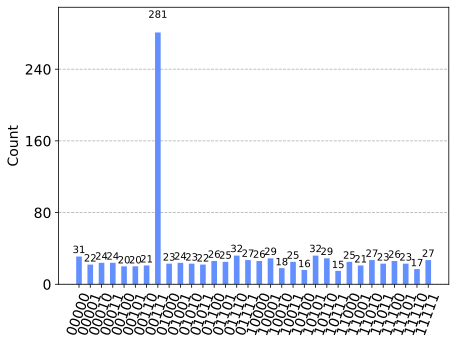

In [71]:
plot_histogram(result.circuit_results)

Se ve claramente que la única opción a seguir es la dada por la secuencia $\verb|1 1 1 0 0|$ ya comentada ($\verb|0 0 1 1 1|$ en los resultados).

## EJERCICIO: Implementar esto en un dispositivo con ruido

Utiliza un simulador con ruido y cuenta las puertas y profundidad del circuito transpilado para resolver este problema 5-SAT

Dibuja el circuito

In [72]:
from qiskit.providers.fake_provider import FakeVigo

# Tomamos un backend ruidoso ficticio de fake providers
device_backend = FakeVigo()

# Creamos el oráculo del problema y aplicamos Grover
oracle = PhaseOracle.from_dimacs_file("5sat.dimacs")
quantum_instance = QuantumInstance(device_backend, shots=1024)
problem = AmplificationProblem(oracle=oracle)

# Usamos el algoritmo de Grover para la resolución
grover = Grover(quantum_instance=quantum_instance)
result = grover.amplify(problem)
print(result) # Imprimimos el resultado

/tmp/ipykernel_1660/1655242840.py:8: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(device_backend, shots=1024)
/tmp/ipykernel_1660/1655242840.py:12: DeprecationWarning: ``qiskit.algorithms.amplitude_amplifiers.grover.Grover.__init__()``'s argument ``quantum_instance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. Instead, use the ``sampler`` argument. See https://qisk.it/algo_migration for a migration guide.
  grover = Grover(quantum_instance=quantum_instance)


{   'assignment': '00111',
    'circuit_results': [   {   '00000': 29,
                               '00001': 45,
                               '00010': 34,
                               '00011': 34,
                               '00100': 38,
                               '00101': 27,
                               '00110': 30,
                               '00111': 48,
                               '01000': 38,
                               '01001': 32,
                               '01010': 27,
                               '01011': 28,
                               '01100': 23,
                               '01101': 32,
                               '01110': 22,
                               '01111': 26,
                               '10000': 45,
                               '10001': 36,
                               '10010': 40,
                               '10011': 26,
                               '10100': 24,
                               '10101': 32,
     

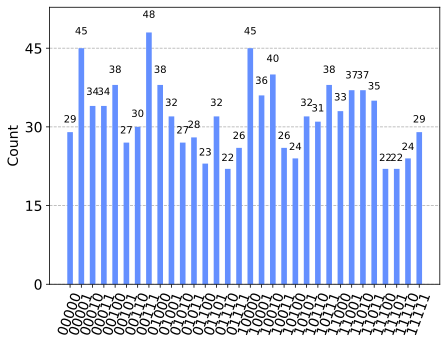

In [73]:
# Mostramos el histograma
plot_histogram(result.circuit_results)

Aunque el resultado más probable sigue siendo el mismo, podemos decir con total seguridad que es posible encontrar casos no deseados. La resolución no es buena. Veamos cómo se implementa el oráculo transpilando el circuito con el simulador de ruido.

/home/codespace/.python/current/lib/python3.10/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


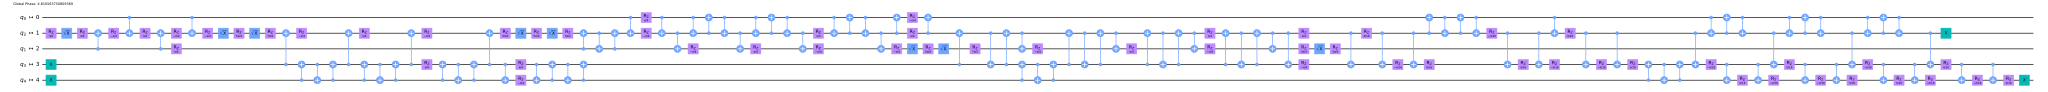

In [74]:
tcirc = transpile(oracle,device_backend)
tcirc.draw("mpl",fold = -1)

Mostramos el número de puertas y la profundidad del circuito.

In [75]:
puertas = tcirc.count_ops() # Numero de puertas
profunfidad = tcirc.depth() # Profunfidad

print(puertas,profunfidad)

OrderedDict([('cx', 98), ('rz', 58), ('sx', 8), ('x', 4)]) 122


Fijate en el numero de puertas de control, son demasiadas puertas CNOT: si cada una de las puertas CNOT tiene un error de aproximadamente 0,5%, entonces no habrá resultados útiles después de 100 puertas aproximadamente).

__NECESITAMOS MEJORES DISPOSITIVOS PARA RESOLVER PROBLEMAS SAT__